# 2025-11-05 Integration

* Midpoint and trapezoid rules

* Extrapolation

 Polynomial interpolation for integration

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Vandermonde with Legendre polynomials
function vander_legendre(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, n)
    if n > 1
        Q[:, 2] = x
    end
    for k in 1:n-2
        Q[:, k+2] = ((2*k + 1) * x .* Q[:, k+1] - k * Q[:, k]) / (k + 1)
    end
    Q
end

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

CosRange (generic function with 1 method)

## Integration

We're interested in computing definite integrals

$$ \int_a^b f \left( x \right) \, dx $$

and will usually consider finite domains $-\infty < a < b < \infty$.

We need to consider

* Cost: (usually) how many times we need to evaluate $f \left( x \right)$

* Accuracy:

    * compare to a reference value
 
    * compare to the same method using more evaluations

We also need to consider how smooth $f \left( x \right)$ is.

## Test functions

We will use these functions to explore our integration.

In [2]:
# One with exponentials
F_expx(x) = exp(2x) / (1 + x^2)
f_expx(x) = 2*exp(2x) / (1 + x^2) - 2x*exp(2x)/(1 + x^2)^2

# And one with tanh
F_dtanh(x) = tanh(x)
f_dtanh(x) = cosh(x)^-2

# And together!
integrands = [f_expx, f_dtanh]
antiderivatives = [F_expx, F_dtanh]
tests = zip(integrands, antiderivatives)

zip(Function[Main.f_expx, Main.f_dtanh], Function[Main.F_expx, Main.F_dtanh])

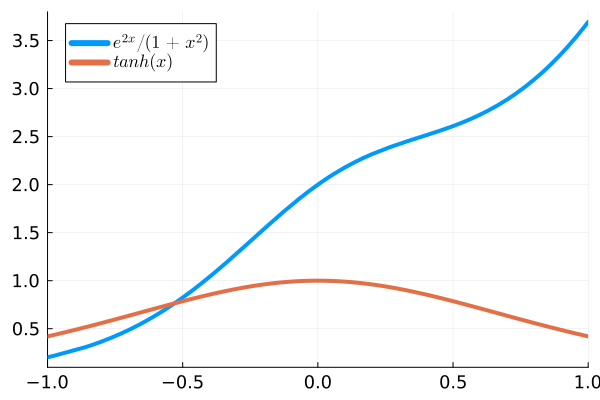

In [3]:
plot(integrands, xlims=(-1, 1), labels=["\$e^{2x} / (1 + x^2)\$" "\$tanh ( x )\$"])

## Fundamental Theorem of Calculus

Let $f \left( x \right)$ be a continuous function and define $F \left( x \right)$ by

$$ F \left( x \right) = \int_a^x f \left( s \right) \, ds $$

Then $F \left( x \right)$ is uniformly continuous, differentiable, and

$$ F' \left( x \right) = f \left( x \right) $$

We say that $F$ is an antiderivative of $f$.
This implies that

$$ \int_a^b f \left( x \right) \, dx = F \left( b \right) - F \left( a \right) $$

We will test the accuracy of our integration schemes using the antiderivatives provided in our tests.

## Method of Manufactured Solutions

We have used manufactured solutions before.
We have a few considerations in this case.

* Analytically integrating an arbitrary function is hard

    * tends to require trickery
 
    * not always possible to express in closed form (see [elliptic integrals](https://en.wikipedia.org/wiki/Elliptic_integral))
 
    * sometimes needs special functions (see $\text{erf} \left( x \right) = 2 / \pi \int_0^x e^{-t^2} \, dt$)
 
    * don't always know when to give up on exact integral

* Analytic differentiation

    * involves straightforward application of product and chain rules

So, if we just choose an arbitrary function $F$ (the antiderivative), then we can compute $f = F'$ and numerically integrate $\int_a^b f$ and compare to $F \left( b \right) - F \left( a \right)$.

## Newton-Cotes methods

Approximate $f \left( x \right)$ using (often low order) piecewise polynomials and integrate the polynomials.

### Midpoint method

Consider using piecewise constant interpolating polynomial.
The area under each constant piece will be equivalent to using the midpoint of each interval and the width of the interval to compute the area of each subinterval (sketch this out!).

In [4]:
# Compute the integral using piecewise constant polynomial fit
function fint_midpoint(f, a, b; n=20)
    dx = (b - a) / n
    # Get the midpoints
    x = LinRange(a + dx/2, b - dx/2, n)
    # Evaluate f at the midpoints and compute areas
    sum(f.(x)) * dx
end

# Let's try it!
for (f, F) in tests
    a, b = -2, 2
    I_num = fint_midpoint(f, a, b, n=20)
    I_analytic = F(b) - F(a)
    println("$f: $I_num error=$(I_num - I_analytic)")
end

f_expx: 10.885522849146847 error=-0.03044402970425253
f_dtanh: 1.9285075531458649 error=0.0004523929942310545


As we saw with interpolation, we can improve accuracy by using more points.

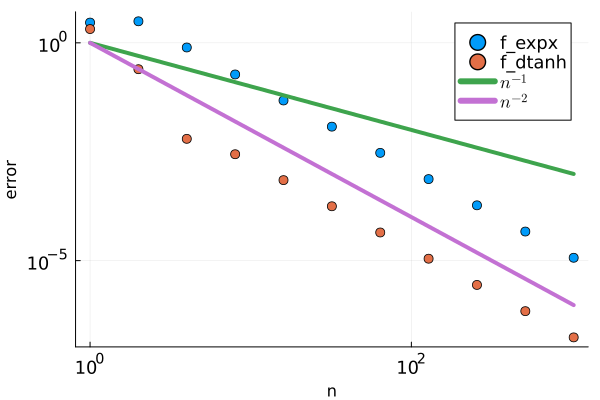

In [5]:
function plot_accuracy(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error")
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    for k in ref
        plot!(ns, ns.^(-1. * k), label="\$n^{-$k}\$")
    end
    p
end
plot_accuracy(fint_midpoint, tests, 2 .^ (0:10))

### Trapezoid rule

The trapezoid rule uses piecewise linear functions on each interval.

$$ \begin{split}\begin{split}
\int_a^b \left[ f \left( a \right) + \frac{f \left( b \right) - f \left( a \right)}{b - a} \left( x - a \right) \right]
  &= f \left( a \right) \left( x - a \right) + \frac{f \left( b \right) - f \left( a \right)}{2 \left( b - a \right)} \left( x - a \right)^2 \Big|_{x = a}^b \\
  &= f \left( a \right) \left( b - a \right) + \frac{f \left( b \right) - f \left( a \right)}{2 \left( b - a \right)} \left( b - a \right)^2 \\
  &= \frac{b - a}{2} \left( f \left( a \right) + f \left( b \right) \right)
\end{split} \end{split} $$

Can you recreate this using a geometric argument (sketch it out!).

What happens when we sum over many adjacent intervals?

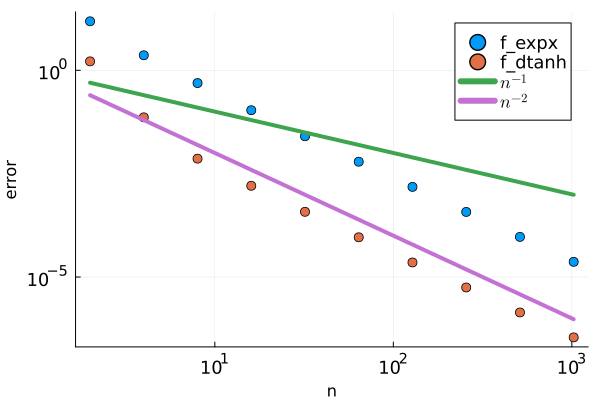

In [6]:
# Compute the integral using piecewise linear polynomial fit
function fint_trapezoid(f, a, b; n=20)
    dx = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    fx = f.(x)
    fx[1] /= 2
    fx[end] /= 2
    sum(fx) * dx
end

plot_accuracy(fint_trapezoid, tests, 2 .^ (1:10))

## Extrapolation

Let's switch our plot to use $h = \Delta x$ instead of the number of points $x$.

In [7]:
function plot_accuracy_h(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="h", ylabel="error",
        legend=:bottomright)
    hs = (b - a) ./ ns
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(hs, Errors, label=f)
    end
    for k in ref
        plot!(hs, .1 * hs.^k, label="\$h^{$k}\$")
    end
    p
end

plot_accuracy_h (generic function with 1 method)

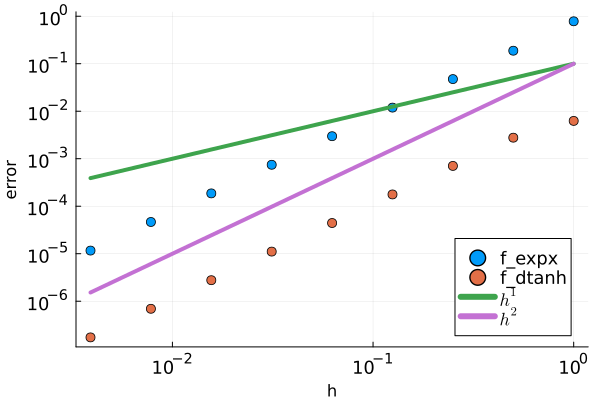

In [8]:
plot_accuracy_h(fint_midpoint, tests, 2 .^ (2:10))

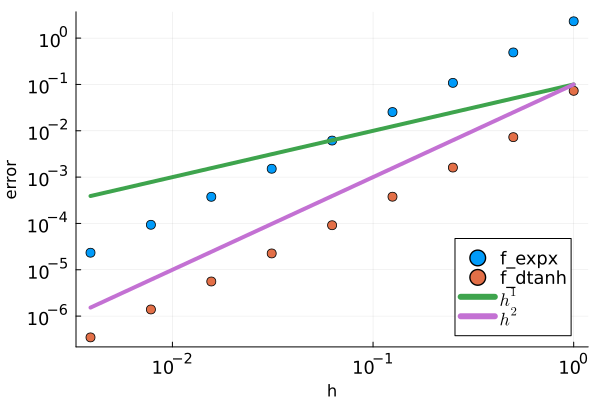

In [9]:
plot_accuracy_h(fint_trapezoid, tests, 2 .^ (2:10))

The trapezoid rule with $n$ points has an interval spacing of $h = 1 / \left( n - 1 \right)$.
Let $I_h$ be the value of the integral approximated using an interval $h$.
We have numerical evidence that the leading error term is $\mathcal{O} \left( h^2 \right)$, which is to say

$$ I_h - I_0 = c h^2 + \mathcal{O} \left( h^3 \right) $$

for some as-yet unknown constant $c$ that will depend upon the function being integrated and the domain of integration. If we can determine $c$ from two approximations, say $I_h$ and $I_{2h}$, then we can extrapolate to $h = 0$.

For sufficiently small $h$, we can neglect $\mathcal{O} \left( h^3 \right)$ and write

$$ \begin{align}
  I_h    - I_0 &= c h^2\\
  I_{2h} - I_0 &= c \left( 2 h \right)^2 
\end{align} $$

Subtracting these two lines, we have

$$ I_h - I_{2h} = c \left( h^2 - 4 h^2 \right) $$

which can be solved for $c$ as

$$ c = \frac{I_h - I_{2h}}{h^2 - 4 h^2} $$

Substituting back into the first equation, we solve for $I_0$ as

$$ I_0 = I_h - c h^2 = I_h + \frac{I_h - I_{2h}}{4 - 1} $$

This is called [**Richardson extrapolation**](https://en.wikipedia.org/wiki/Richardson_extrapolation).

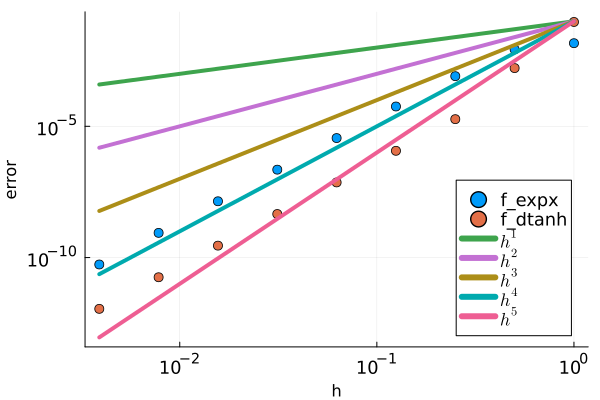

In [10]:
function fint_richardson(f, a, b; n=20)
    n = div(n, 2) * 2 + 1
    h = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    # Evaluate our function once
    fx = f.(x)
    fx[[1, end]] /= 2
    # Itegrate with h and 2h
    I_h = sum(fx) * h
    I_2h = sum(fx[1:2:end]) * 2h
    # Estimate I_0 per our math above
    I_h + (I_h - I_2h) / 3
end

# And how does it do?
plot_accuracy_h(fint_richardson, tests, 2 .^ (2:10), ref=1:5)

We now have a sequence of accurate approximations.
It is possible to apply this extrapolation recursively, and it works great if we have a number of points that is a power of $2$ and our function is "nice enough".

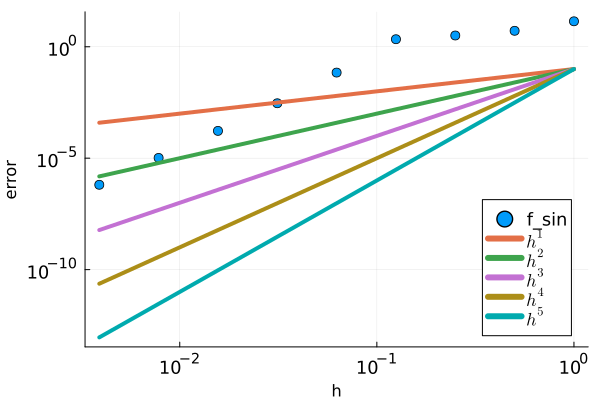

In [11]:
F_sin(x) = sin(30x)
f_sin(x) = 30*cos(30x)
plot_accuracy_h(fint_richardson, zip([f_sin], [F_sin]), 2 .^ (2:10), ref=1:5)

## Polynomial interpolation for integration

Now let's use our work on polynomial interpolation to see if we can develop a different approach to quadrature (numerical integration).

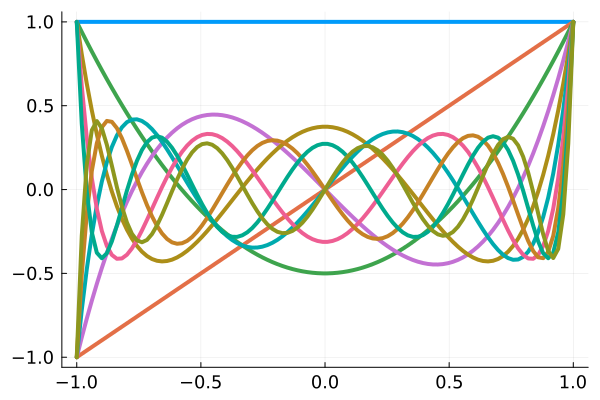

In [12]:
x = LinRange(-1, 1, 100)
P = vander_legendre(x, 10)
plot(x, P, legend=:none)

We want to sample our function $f \left( x \right)$ at some points $x \in \left[ -1, 1 \right]$, fit a polynomial through these points, and return the integral of that interpolating polynomial.

* What points do we sample on?

* How do we integrate the interpolating polynomial?

Recall that the Legendre polynomials $P_0 \left( x \right) = 1$, $P_1 \left( x \right) = x$, $\dots$, are pairwise orthogonal

$$ \int_{-1}^1 P_m \left( x \right) P_n \left( x \right) = 0, \forall m \neq n $$

### Let's see the code

In [13]:
function plot_accuracy_n(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error",
        legend=:bottomright)
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    p
end

plot_accuracy_n (generic function with 1 method)

In [14]:
function fint_legendre(f, a, b; n=20)
    x = CosRange(-1, 1, n)
    P = vander_legendre(x)
    x_ab = (a+b)/2 .+ (b-a)/2*x
    c = P \ f.(x_ab)
    (b - a) * c[1]
end

fint_legendre(x -> 1 + x, -1, 1, n=2)

2.0

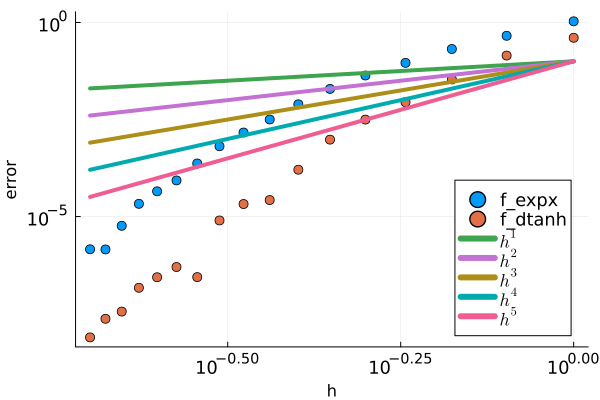

In [15]:
p = plot_accuracy_h(fint_legendre, tests, 4:20, ref=1:5)

This appears to be beating out approach above.
There has to be some drawbacks or potential issues though.